## does further localising sparse representation help?

- previously we observed, localising to one layer, with sparse representation : demonstrate results, generalisable, beyond test cases to perturbed test cases as well. 

- within this sparse representation: although sparse it is nevertheless a large data dimension of 32768, can increase space and time complexity required compared to evaluating via the original probe of dimension 512

Goal: can we reduce features required / achieve a more parsimonious model? 

Objective: Does classifying based on a subset of 'relevant' features still achieve accurate, robust classification of harmful prompts?

- Method: how to locate more relevant features?
    1. locate by correlation 
    2. locate by causal score 

Measure of success: 

- Quantitative: Accuracy and Recall
    - what is the accuracy and recall of taking localised latents to classify harmful vs non harmful prompts?
    - Observation: 
        - Corr: poor recall score on perturbed data (0)

- Qualitative: visualise distribution of different testsets 
    - both set of latents capture clear distribution differences for perturbed data
    - Observation: 
        - Corr: distribution on perturbed data seem more similar to nonharmful prompt distributions 

Notebook outline: 
- setup: load train, test, test_perturbed acts 

- method: get localised features 
    - correlation (probe weights)
    - causal score (ablation effects)

- train, test localised classifier

- viz: sparse activation distribution - test vs test_perturbed
- viz: causal distribution of sparse latents  
    - representing latents "contributing" (having most logits impact on classification of harmful prompts)

Side notes: 


- Question: what is the difference between corr vs causal score as measures of relation between 2 rep spaces? (latent representation vs concept representation)

- notes: 
    - both ways of locating resulted in rather different top latents..
    - latent by correlation seem more interpretable than latent by causal score - https://www.neuronpedia.org/p70d-sm

    - latents by correlation classify more accurately 
    - latents causal score classify more robustly? (tbc further)



In [1]:
from utils.probe_utils import load_probe, data_loader, test_probe
from utils.data_utils import read_from_pt_gz, save_to_pt_gz
import torch as t 
from tqdm import tqdm

sae_dim = 32768

### set up

In [4]:
## train acts
harmful_fp = "data_latents/train/sparse_acts/harmful_sparse_acts_32768.pt.gz"
nonharmful_fp = "data_latents/train/sparse_acts/nonharmful_sparse_acts_32768.pt.gz"

harmful_sparse_acts_train = read_from_pt_gz(harmful_fp)
nonharmful_sparse_acts_train = read_from_pt_gz(nonharmful_fp)


/Users/roselin/Desktop/locating_latent_rep_of_harm/utils/data_utils.py:31: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return t.load(f)


In [ ]:
# test acts
nonharmful_acts_test = read_from_pt_gz("data_latents/test/sparse_acts/nonharmful_sparse_acts_32768.pt.gz")
harmful_acts_test = read_from_pt_gz("data_latents/test/sparse_acts/harmful_sparse_acts_32768.pt.gz")
harmful_acts_test_perturbed = read_from_pt_gz("data_latents/test_perturbed/sparse_acts/harmful_sparse_acts_32768.pt.gz")


/Users/roselin/Desktop/locating_latent_rep_of_harm/utils/data_utils.py:31: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return t.load(f)


In [125]:
harmful_acts_test_perturbed.shape, harmful_acts_test.shape, nonharmful_acts_test.shape

(torch.Size([192, 169, 32768]),
 torch.Size([192, 31, 32768]),
 torch.Size([192, 38, 32768]))

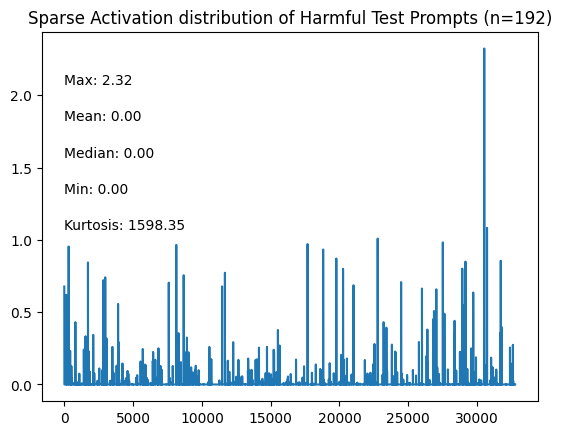

In [169]:
from scipy.stats import kurtosis
import matplotlib.pyplot as plt

plt.title('Sparse Activation distribution of Harmful Test Prompts (n=192)')
harmful_data = harmful_acts_test[:, -1, :].mean(0)
stats = {
        "max": harmful_data.max(),
        "mean": harmful_data.mean(),
        "median": harmful_data.median(),
        "min": harmful_data.min(), 
        "kurtosis": kurtosis(harmful_data)
    }
# Annotate statistics
plt.text(stats['max'] + 2, stats['max'] - 0.25, f"Max: {stats['max']:.2f}", fontsize=10, ha='left')
plt.text(stats['max'] + 2, stats['max'] - 0.5, f"Mean: {stats['mean']:.2f}", fontsize=10, ha='left')
plt.text(stats['max'] + 2, stats['max'] - 0.75 , f"Median: {stats['median']:.2f}", fontsize=10, ha='left')
plt.text(stats['max'] + 2, stats['max'] - 1.0, f"Min: {stats['min']:.2f}", fontsize=10, ha='left')
plt.text(stats['max'] + 2, stats['max'] - 1.25, f"Kurtosis: {stats['kurtosis']:.2f}", fontsize=10, ha='left')

plt.plot(harmful_acts_test[:, -1, :].mean(0).detach().numpy())



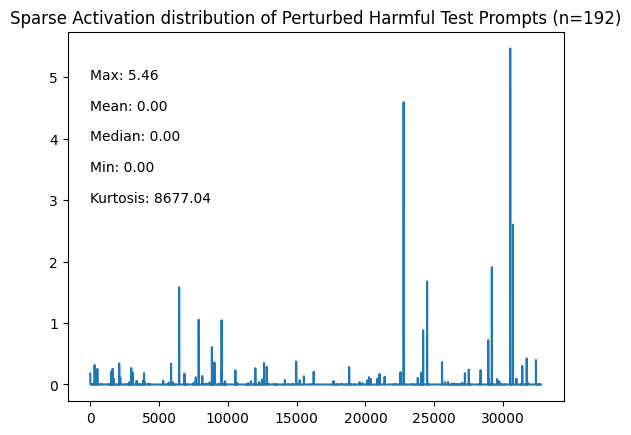

In [123]:
plt.title('Sparse Activation distribution of Perturbed Harmful Test Prompts (n=192)')
harmful_data = harmful_acts_test_perturbed[:, -1, :].mean(0)
stats = {
        "max": harmful_data.max(),
        "mean": harmful_data.mean(),
        "median": harmful_data.median(),
        "min": harmful_data.min(), 
        "kurtosis": kurtosis(harmful_data)
    }
# Annotate statistics
plt.text(stats['max'] + 2, stats['max'] - 0.5, f"Max: {stats['max']:.2f}", fontsize=10, ha='left')
plt.text(stats['max'] + 2, stats['max'] - 1, f"Mean: {stats['mean']:.2f}", fontsize=10, ha='left')
plt.text(stats['max'] + 2, stats['max'] - 1.5, f"Median: {stats['median']:.2f}", fontsize=10, ha='left')
plt.text(stats['max'] + 2, stats['max'] - 2, f"Min: {stats['min']:.2f}", fontsize=10, ha='left')
plt.text(stats['max'] + 2, stats['max'] - 2.5, f"Kurtosis: {stats['kurtosis']:.2f}", fontsize=10, ha='left')

plt.plot(harmful_acts_test_perturbed[:, -1, :].mean(0).detach().numpy())

## get top latents by probe weights

In [13]:
filepath = "concept_probe/sparse_acts_probe/sparse_acts_probe_3_epoches.pth"
sparse_acts_probe = load_probe(filepath, dim=sae_dim)
sparse_acts_probe

Probe(
  (net): Linear(in_features=32768, out_features=1, bias=True)
)

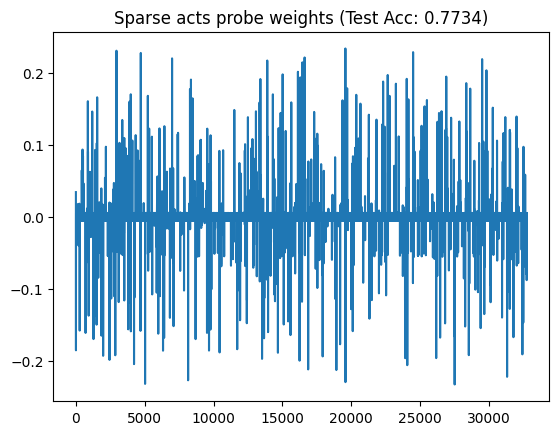

In [27]:
import matplotlib.pyplot as plt
plt.title(f"Sparse acts probe weights (Test Acc: {test_acc:.4f})")
plt.plot(sparse_acts_probe.net.weight.squeeze().detach().numpy())

In [ ]:
corr_latents_top_100 = abs(sparse_acts_probe.net.weight.squeeze()).topk(100)
corr_latents_top_100.indices

tensor([19584, 27524,  5028,  2948, 19589, 24504,  4716,  8155, 31335, 16620,
         6989, 29521, 13906, 16458, 18928, 16879, 24081,  4225, 29833, 16135,
        16254,  2443, 15025, 13528, 22660, 23935, 26184, 26914, 17932, 16308,
         1980,  2862, 28554, 24041, 13405, 32446,  8362, 14681, 10442, 22326,
         6332,  9674, 28368,     5, 23254, 11723, 19713, 28655,  8291, 19200,
         3987, 14314,  8698,  1279, 20375, 13673,  5228,  6412, 22795, 26469,
        31796, 27541,  1546,  1858,  8476, 15595, 24162,  5986, 25509, 19375,
          703,  9528,   869, 13964,  3898,  3994, 15651, 13347, 20118,  4695,
          276, 20677,  9779,  3803, 29413, 25335, 28287,  7097, 30296,  1503,
        15104, 11511, 26829, 12420, 32511, 26571, 13084,  1187, 17315, 15421])

## get top latents by causal score

#### causal distribution by mean (nonzero=576)

In [ ]:
# gather ablation effects for one layer
acts = harmful_sparse_acts_train
probe = sparse_acts_probe

# based on last token
active_latents = len(acts.mean(dim=(1)).nonzero()[:, 1].unique())

ablation_effects = t.zeros(sae_dim)

full_acts = acts.mean(dim=1)
logits = probe(full_acts)

for latent_idx in tqdm(range(1, active_latents)): 
    ablated_acts = full_acts.clone()
    # ablate latent
    ablated_acts[:, latent_idx] = 0.0
    # compute logits_with_ablation
    logits_with_ablation = probe(ablated_acts)

    ablation_effects[latent_idx] = (logits - logits_with_ablation).mean() # over prompts

harmful_causal_dist = ablation_effects


  0%|          | 0/4285 [00:00<?, ?it/s]

100%|██████████| 4285/4285 [00:09<00:00, 470.56it/s]


In [26]:
save_to_pt_gz("data_latents/train/causal_dist/harmful_ablation_effects.pt.gz", harmful_causal_dist)

saved to  data_latents/train/causal_dist/harmful_ablation_effects.pt.gz


In [ ]:
harmful_causal_dist.nonzero().numel() # 576

576

Text(0.5, 0, 'Sparse latent index (Non-zero Counts: 576)')

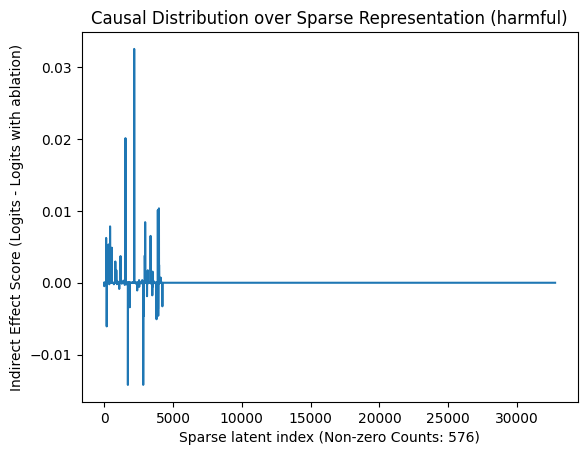

In [24]:
# import matplotlib.pyplot as plt
plt.title(f"Causal Distribution over Sparse Representation (harmful)")
plt.plot(harmful_causal_dist.detach().numpy())
# Add text to the plot
plt.ylabel("Indirect Effect Score (Logits - Logits with ablation)")
plt.xlabel(f"Sparse latent index (Non-zero Counts: {harmful_causal_dist.nonzero().numel()})")

In [ ]:
abs(harmful_causal_dist).topk(100)
### representing latents "contributing" (having most logits impact on classification of harmful prompts)

torch.return_types.topk(
values=tensor([3.2564e-02, 2.0137e-02, 1.4227e-02, 1.4220e-02, 1.0361e-02, 1.0119e-02,
        8.4373e-03, 7.8517e-03, 6.5271e-03, 6.2400e-03, 6.0775e-03, 5.3389e-03,
        5.0794e-03, 4.8842e-03, 4.6444e-03, 4.5921e-03, 3.7901e-03, 3.7149e-03,
        3.6188e-03, 3.4152e-03, 3.2794e-03, 2.9590e-03, 2.4894e-03, 1.8726e-03,
        1.7507e-03, 1.7504e-03, 1.7407e-03, 1.5493e-03, 1.0744e-03, 8.6228e-04,
        8.1844e-04, 8.0281e-04, 7.9939e-04, 7.2246e-04, 5.8451e-04, 5.6797e-04,
        5.4440e-04, 4.7687e-04, 4.7117e-04, 3.9969e-04, 3.6946e-04, 3.6832e-04,
        3.6791e-04, 3.0588e-04, 2.9303e-04, 2.8624e-04, 2.6646e-04, 2.4915e-04,
        2.2737e-04, 2.0922e-04, 2.0899e-04, 2.0860e-04, 1.9752e-04, 1.9408e-04,
        1.8745e-04, 1.7974e-04, 1.6817e-04, 1.4947e-04, 1.4721e-04, 1.4636e-04,
        1.3731e-04, 1.3416e-04, 1.3388e-04, 1.3056e-04, 1.2725e-04, 1.1681e-04,
        1.1462e-04, 1.1427e-04, 1.0659e-04, 1.0455e-04, 8.8112e-05, 8.3935e-05,
        

#### causal distribution by last token (nonzero=only 7.. )


In [11]:
acts = harmful_sparse_acts_train
probe = sparse_acts_probe

# active latents of last tok activations 
active_latents = len(acts[:, -1, :].nonzero()[:, 1].unique())

ablation_effects = t.zeros(sae_dim)

# last tok activations of the batch
full_acts = acts[:, -1, :]
logits = probe(full_acts)

for latent_idx in tqdm(range(1, active_latents)): 
    ablated_acts = full_acts.clone()
    # ablate last tok activation of latent idx
    ablated_acts[:, latent_idx] = 0.0
    # compute logits_with_ablation
    logits_with_ablation = probe(ablated_acts)

    ablation_effects[latent_idx] = (logits - logits_with_ablation).mean() # over prompts

harmful_causal_dist = ablation_effects

print(len(harmful_causal_dist))

100%|██████████| 511/511 [00:00<00:00, 514.53it/s]


32768


In [16]:
harmful_causal_dist.nonzero().numel() # 576

7

In [15]:
harmful_causal_dist.max(), harmful_causal_dist.mean(), harmful_causal_dist.min()

(tensor(0.0227, grad_fn=<MaxBackward1>),
 tensor(9.2457e-07, grad_fn=<MeanBackward0>),
 tensor(-0.0197, grad_fn=<MinBackward1>))

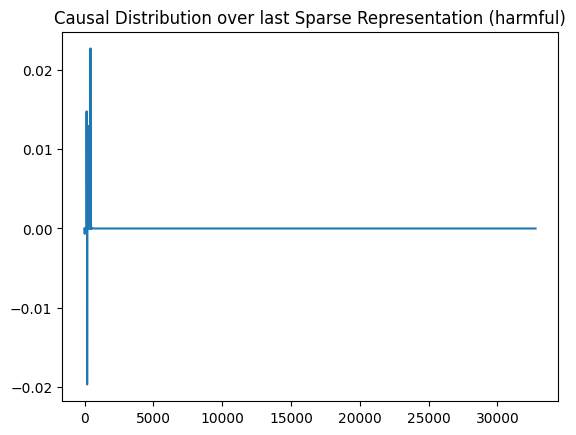

In [17]:
import matplotlib.pyplot as plt
plt.title(f"Causal Distribution over last Sparse Representation (harmful)")
plt.plot(harmful_causal_dist.detach().numpy())

### only afew have significant causal effects 

In [18]:
harmful_causal_dist.topk(100)

torch.return_types.topk(
values=tensor([2.2722e-02, 1.4783e-02, 1.2962e-02, 1.7165e-04, 9.3281e-06, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        

## train test localised probe:


In [ ]:
# top_100_corr = set([19584, 27524,  5028,  2948, 19589, 24504,  4716,  8155, 31335, 16620,
#          6989, 29521, 13906, 16458, 18928, 16879, 24081,  4225, 29833, 16135,
#         16254,  2443, 15025, 13528, 22660, 23935, 26184, 26914, 17932, 16308,
#          1980,  2862, 28554, 24041, 13405, 32446,  8362, 14681, 10442, 22326,
#          6332,  9674, 28368,     5, 23254, 11723, 19713, 28655,  8291, 19200,
#          3987, 14314,  8698,  1279, 20375, 13673,  5228,  6412, 22795, 26469,
#         31796, 27541,  1546,  1858,  8476, 15595, 24162,  5986, 25509, 19375,
#           703,  9528,   869, 13964,  3898,  3994, 15651, 13347, 20118,  4695,
#           276, 20677,  9779,  3803, 29413, 25335, 28287,  7097, 30296,  1503,
#         15104, 11511, 26829, 12420, 32511, 26571, 13084,  1187, 17315, 15421])

# top_100_causal = set([2180, 1546, 3978, 3898, 2977,  427, 3370,  141,  319,  552, 2948, 1187,
#          808, 3987,  880, 3167, 3517,  516, 3067, 4103, 1518, 2534, 2763,  869,
#         1396, 3065, 3578, 2973,  483, 1422, 2510, 1022, 1227, 3997, 3937, 1510,
#         2269, 2730, 3352, 2104, 1624, 1859, 3960, 2520, 3191, 4015, 1702,   35,
#         3909, 1848, 3768, 2962, 2714, 2749, 2064, 3604, 2211, 1969, 1751, 3471,
#          448, 3741, 3837,  573,  848, 1786, 1511, 3719, 1239, 3297, 2923,  900,
#         2438, 1446, 3804, 4213, 2437, 3049, 3336,  225,  337,  249,   14, 1213,
#         3770, 2115,  193,  978, 3766, 2088, 1277, 3355, 2658,  871, 2877, 3950,
#          780, 3958,  627,   62])

In [ ]:
top_100_corr = abs(sparse_acts_probe.net.weight.squeeze()).topk(100).indices
top_100_causal = abs(harmful_causal_dist).topk(100).indices

In [92]:
from torch import nn 

class Probe(nn.Module):
    def __init__(self, activation_dim):
        super().__init__()
        self.net = nn.Linear(activation_dim, 1, bias=True)

    def forward(self, x):
        logits = self.net(x).squeeze(-1)
        return logits
    
def train_probe(probe, batches, lr=1e-2):
    
    optimizer = t.optim.AdamW(probe.parameters(), lr=lr)
    criterion = nn.BCEWithLogitsLoss()
    losses = []

    for batch in batches:
        
        acts = batch[0]
        labels = batch[1] 
        logits = probe(acts)
        loss = criterion(logits, labels.float())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        losses.append(loss.item())

    return probe, losses

def train(linear_probe_dim, train_batches, test_batches, epoches=65): 
    t.manual_seed(42)
    probe = Probe(linear_probe_dim)

    epoch_train_loss = []
    total_loss = []
    epoch_test_acc = []
    epoches = epoches

    # train_batches = batches[:-2]

    for i in range(epoches): 
        probe, losses = train_probe(probe, train_batches)
        total_loss.extend(losses)
        epoch_train_loss.append(losses[-1])

        test_acc = test_probe(probe, batches=test_batches, seed=42)
        epoch_test_acc.append(test_acc)
    
    return probe, epoch_train_loss, epoch_test_acc, total_loss

#### probe localised by max ablation effects (causal score)
- train probe over top 100 latent (by max causal score)

In [133]:
top_100_causal = abs(harmful_causal_dist).topk(100).indices

nonharmful_acts = nonharmful_sparse_acts_train[:, :, top_100_causal]
harmful_acts = harmful_sparse_acts_train[:, :, top_100_causal]

save_to_pt_gz("data_latents/train/localised_sparse_acts/nonharmful_causally_localised_sparse_acts.pt.gz", nonharmful_acts)
save_to_pt_gz("data_latents/train/localised_sparse_acts/harmful_causally_localised_sparse_acts.pt.gz", harmful_acts)
last_tok_acts_data = t.cat((nonharmful_acts[:, -1, :], harmful_acts[:, -1, :]), dim=0).tolist()
label = t.cat( (t.zeros(len(nonharmful_acts)) , t.ones(len(harmful_acts))) )
train_batches = data_loader(last_tok_acts_data, label)
print(len(train_batches))

saved to  data_latents/train/localised_sparse_acts/nonharmful_causally_localised_sparse_acts.pt.gz
saved to  data_latents/train/localised_sparse_acts/harmful_causally_localised_sparse_acts.pt.gz
8


In [134]:
nonharmful_acts = nonharmful_acts_test[:, :, top_100_causal]
harmful_acts = harmful_acts_test[:, :, top_100_causal]

save_to_pt_gz("data_latents/test/localised_sparse_acts/nonharmful_causally_localised_sparse_acts.pt.gz", nonharmful_acts)
save_to_pt_gz("data_latents/test/localised_sparse_acts/harmful_causally_localised_sparse_acts.pt.gz", harmful_acts)

last_tok_acts_data = t.cat((nonharmful_acts[:, -1, :], harmful_acts[:, -1, :]), dim=0).tolist()
label = t.cat( (t.zeros(len(nonharmful_acts)) , t.ones(len(harmful_acts))) )
test_batches = data_loader(last_tok_acts_data, label)
print(len(test_batches))


saved to  data_latents/test/localised_sparse_acts/nonharmful_causally_localised_sparse_acts.pt.gz
saved to  data_latents/test/localised_sparse_acts/harmful_causally_localised_sparse_acts.pt.gz
24


In [ ]:
causal_local_probe, epoch_train, epoch_test, total_loss = train(linear_probe_dim=100, train_batches=train_batches, test_batches=test_batches)

save_to_pt_gz("concept_probe/localised_probes/causally_localised_probe.pth", causal_local_probe)

saved to  concept_probe/localised_probes/causally_localised_probe.pth


#### results

Text(0, 0.5, 'Values')

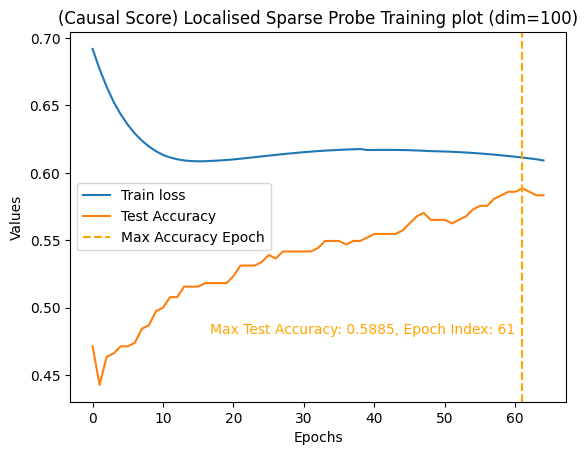

In [ ]:
epoch_train_loss = epoch_train
epoch_test_acc = epoch_test

max_value = t.tensor(epoch_test_acc).topk(1).values.numpy().item()
max_epoch = t.tensor(epoch_test_acc).topk(1).indices.numpy().item()

plt.plot(epoch_train_loss, label="Train loss")
plt.plot(epoch_test_acc, label="Test Accuracy")

plt.text(max_epoch-1, epoch_test_acc[-1] - 0.1, f"Max Test Accuracy: {max_value:.4f}, Epoch Index: {max_epoch}", 
        ha='right', va='center', fontsize=10, color="orange")

# Add a vertical line at the max test accuracy epoch
plt.axvline(x=max_epoch, color='orange', linestyle='--', label="Max Accuracy Epoch")

plt.legend()
plt.title("(Causal Score) Localised Sparse Probe Training plot (dim=100)")
# Add axis labels
plt.xlabel("Epochs")
plt.ylabel("Values")

In [141]:
harmful_acts = harmful_acts_test[:, :, top_100_causal]
last_tok_acts_data = harmful_acts[:, -1, :].tolist()
label = t.ones(len(harmful_acts))
test_batches_harmful = data_loader(last_tok_acts_data, label)

print("Recall (harmful)", test_probe(causal_local_probe, test_batches_harmful))


Recall (harmful) 0.5520833134651184


In [142]:

harmful_acts = harmful_acts_test_perturbed[:, :, top_100_causal]
save_to_pt_gz("data_latents/test_perturbed/localised_sparse_acts/harmful_causally_localised_sparse_acts.pt.gz", harmful_acts)

last_tok_acts_data = harmful_acts[:, -1, :].tolist()
label = t.ones(len(harmful_acts))
test_batches_harmful_perturbed = data_loader(last_tok_acts_data, label)

# test_probe(corrprobe, test_batches_harmful_perturbed)

print("Recall (harmful perturbed)", test_probe(causal_local_probe, test_batches_harmful_perturbed))

saved to  data_latents/test_perturbed/localised_sparse_acts/harmful_causally_localised_sparse_acts.pt.gz
Recall (harmful perturbed) 0.3489583432674408


#### probe localised by max weights (correlation score)

In [ ]:
### get train activations by (top 100 latents)
### take last token activations

nonharmful_acts = nonharmful_sparse_acts_train[:, :, top_100_corr]
harmful_acts = harmful_sparse_acts_train[:, :, top_100_corr]

save_to_pt_gz("data_latents/train/localised_sparse_acts/nonharmful_corr_localised_sparse_acts.pt.gz", nonharmful_acts)
save_to_pt_gz("data_latents/train/localised_sparse_acts/harmful_corr_localised_sparse_acts.pt.gz", harmful_acts)
last_tok_acts_data = t.cat((nonharmful_acts[:, -1, :], harmful_acts[:, -1, :]), dim=0).tolist()
label = t.cat( (t.zeros(len(nonharmful_acts)) , t.ones(len(harmful_acts))) )
train_batches = data_loader(last_tok_acts_data, label)


saved to  data_latents/train/localised_sparse_acts/nonharmful_corr_localised_sparse_acts.pt.gz
saved to  data_latents/train/localised_sparse_acts/harmful_corr_localised_sparse_acts.pt.gz


In [ ]:
nonharmful_acts = nonharmful_acts_test[:, :, top_100_corr]
harmful_acts = harmful_acts_test[:, :, top_100_corr]

save_to_pt_gz("data_latents/test/localised_sparse_acts/nonharmful_corr_localised_sparse_acts.pt.gz", nonharmful_acts)
save_to_pt_gz("data_latents/test/localised_sparse_acts/harmful_corr_localised_sparse_acts.pt.gz", harmful_acts)

last_tok_acts_data = t.cat((nonharmful_acts[:, -1, :], harmful_acts[:, -1, :]), dim=0).tolist()
label = t.cat( (t.zeros(len(nonharmful_acts)) , t.ones(len(harmful_acts))) )
test_batches = data_loader(last_tok_acts_data, label)


saved to  data_latents/test/localised_sparse_acts/nonharmful_corr_localised_sparse_acts.pt.gz
saved to  data_latents/test/localised_sparse_acts/harmful_corr_localised_sparse_acts.pt.gz


In [ ]:
corr_probe, epoch_train, epoch_test, total_loss = train(linear_probe_dim=100, train_batches=train_batches, test_batches=test_batches)

save_to_pt_gz("concept_probe/localised_probes/corr_localised_probe.pth", corr_probe)


#### results

In [153]:
harmful_acts = harmful_acts_test[:, :, top_100_corr]
save_to_pt_gz("data_latents/test/localised_sparse_acts/harmful_corr_localised_sparse_acts.pt.gz", harmful_acts)

last_tok_acts_data = harmful_acts[:, -1, :].tolist()
label = t.ones(len(harmful_acts))
test_batches_harmful = data_loader(last_tok_acts_data, label)

print("Recall (harmful)", test_probe(corr_probe, test_batches_harmful))

saved to  data_latents/test/localised_sparse_acts/harmful_corr_localised_sparse_acts.pt.gz
Recall (harmful) 0.59375


In [ ]:

harmful_acts = harmful_acts_test_perturbed[:, :, top_100_corr]
save_to_pt_gz("data_latents/test_perturbed/localised_sparse_acts/harmful_corr_localised_sparse_acts.pt.gz", harmful_acts)

last_tok_acts_data = harmful_acts[:, -1, :].tolist()
label = t.ones(len(harmful_acts))
test_batches_harmful_perturbed = data_loader(last_tok_acts_data, label)

# test_probe(corrprobe, test_batches_harmful_perturbed)

print("Recall (harmful perturbed)", test_probe(corr_probe, test_batches_harmful_perturbed))

saved to  data_latents/test/localised_sparse_acts/harmful_corr_localised_sparse_acts.pt.gz
Recall (harmful perturbed) 0.0


Text(0, 0.5, 'Values')

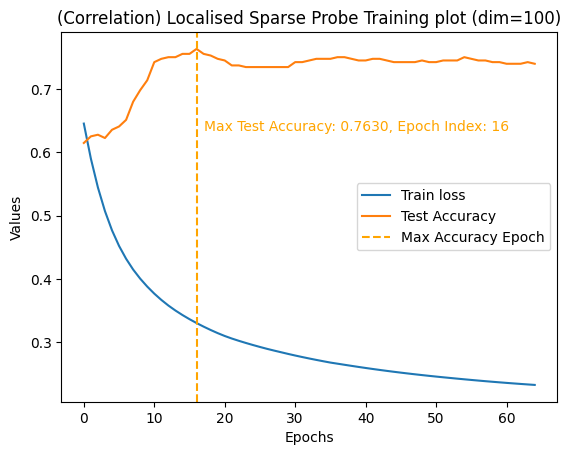

In [95]:
epoch_train_loss = epoch_train
epoch_test_acc = epoch_test

max_value = t.tensor(epoch_test_acc).topk(1).values.numpy().item()
max_epoch = t.tensor(epoch_test_acc).topk(1).indices.numpy().item()

plt.plot(epoch_train_loss, label="Train loss")
plt.plot(epoch_test_acc, label="Test Accuracy")

plt.text(max_epoch + 1, epoch_test_acc[-1] - 0.1, f"Max Test Accuracy: {max_value:.4f}, Epoch Index: {max_epoch}", 
        ha='left', va='center', fontsize=10, color="orange")

# Add a vertical line at the max test accuracy epoch
plt.axvline(x=max_epoch, color='orange', linestyle='--', label="Max Accuracy Epoch")

plt.legend()
plt.title("(Correlation) Localised Sparse Probe Training plot (dim=100)")

# Add axis labels
plt.xlabel("Epochs")
plt.ylabel("Values")

## visualisation: top 100 latent sparse distribution 

### by causal score: train, test, test_perturbed

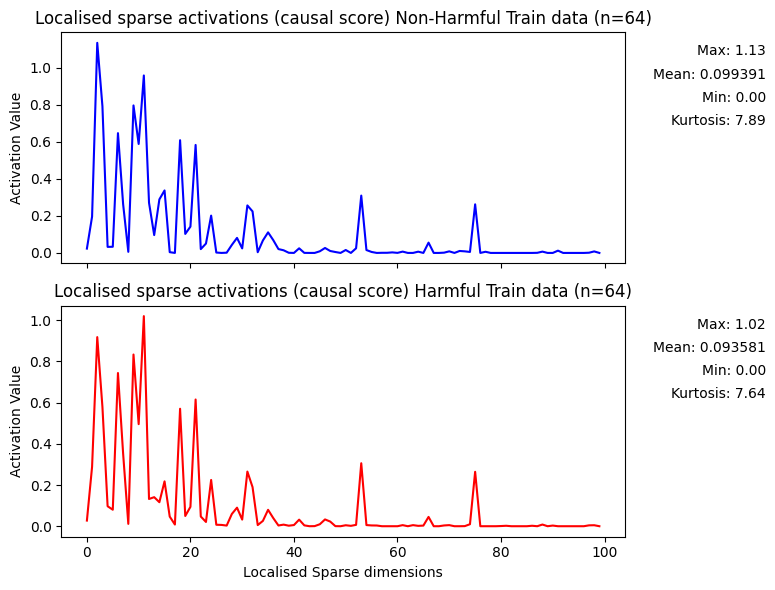

In [194]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import kurtosis

harmful_acts = harmful_sparse_acts_train[:, :, top_100_causal]
nonharmful_acts = nonharmful_sparse_acts_train[:, :, top_100_causal]

harmful_data = harmful_acts[:, -1, :].mean(0)
nonharmful_data = nonharmful_acts[:, -1, :].mean(0)

harmful_stats = {
    "max": harmful_data.max(),
    "mean": harmful_data.mean(),
    "min": harmful_data.min(), 
    "kurtosis": kurtosis(harmful_data)
}
nonharmful_stats = {
    "max": nonharmful_data.max(),
    "mean": nonharmful_data.mean(),
    "min": nonharmful_data.min(), 
    "kurtosis": kurtosis(nonharmful_data)
}

# Create two subplots stacked vertically
fig, axes = plt.subplots(2, 1, figsize=(8, 6), sharex=True)

# Plot non-harmful data
axes[0].plot(nonharmful_data, label="Non-harmful data", color='blue')
axes[0].set_title("Localised sparse activations (causal score) Non-Harmful Train data (n=64)")
# axes[0].legend()
axes[0].set_ylabel("Activation Value")

# Annotate statistics
axes[0].text(1.25, 0.9, f"Max: {nonharmful_stats['max']:.2f}", transform=axes[0].transAxes, fontsize=10, ha='right')
axes[0].text(1.25, 0.8, f"Mean: {nonharmful_stats['mean']:.6f}", transform=axes[0].transAxes, fontsize=10, ha='right')
axes[0].text(1.25, 0.7, f"Min: {nonharmful_stats['min']:.2f}", transform=axes[0].transAxes, fontsize=10, ha='right')
axes[0].text(1.25, 0.6, f"Kurtosis: {nonharmful_stats['kurtosis']:.2f}", transform=axes[0].transAxes, fontsize=10, ha='right')

# Plot harmful data
axes[1].plot(harmful_data, label="Harmful data", color='red')
axes[1].set_title("Localised sparse activations (causal score) Harmful Train data (n=64)")

axes[1].set_xlabel("Localised Sparse dimensions")
axes[1].set_ylabel("Activation Value")
# Annotate statistics
axes[1].text(1.25, 0.9, f"Max: {harmful_stats['max']:.2f}", transform=axes[1].transAxes, fontsize=10, ha='right')
axes[1].text(1.25, 0.8, f"Mean: {harmful_stats['mean']:.6f}", transform=axes[1].transAxes, fontsize=10, ha='right')
axes[1].text(1.25, 0.7, f"Min: {harmful_stats['min']:.2f}", transform=axes[1].transAxes, fontsize=10, ha='right')
axes[1].text(1.25, 0.6, f"Kurtosis: {harmful_stats['kurtosis']:.2f}", transform=axes[1].transAxes, fontsize=10, ha='right')


# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


torch.Size([192, 169, 100])


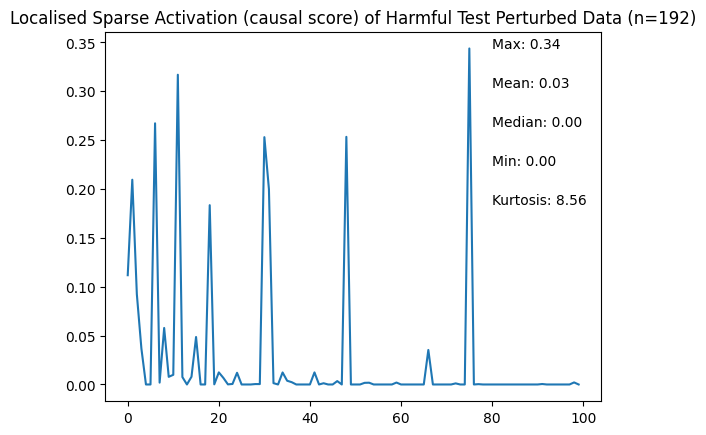

In [196]:
harmful_acts = harmful_acts_test_perturbed[:, :, top_100_causal]
print(harmful_acts.shape)
plt.title(f'Localised Sparse Activation (causal score) of Harmful Test Perturbed Data (n={harmful_acts.shape[0]})')
harmful_data = harmful_acts[:, -1, :].mean(0)
stats = {
        "max": harmful_data.max(),
        "mean": harmful_data.mean(),
        "median": harmful_data.median(),
        "min": harmful_data.min(), 
        "kurtosis": kurtosis(harmful_data)
    }
# Annotate statistics
plt.text(80, stats['max'], f"Max: {stats['max']:.2f}", fontsize=10, ha='left')
plt.text(80, stats['max'] - 0.04, f"Mean: {stats['mean']:.2f}", fontsize=10, ha='left')
plt.text(80, stats['max'] - 0.08, f"Median: {stats['median']:.2f}", fontsize=10, ha='left')
plt.text(80, stats['max'] - 0.12, f"Min: {stats['min']:.2f}", fontsize=10, ha='left')
plt.text(80, stats['max'] - 0.16, f"Kurtosis: {stats['kurtosis']:.2f}", fontsize=10, ha='left')

plt.plot(harmful_acts[:, -1, :].mean(0).detach().numpy())



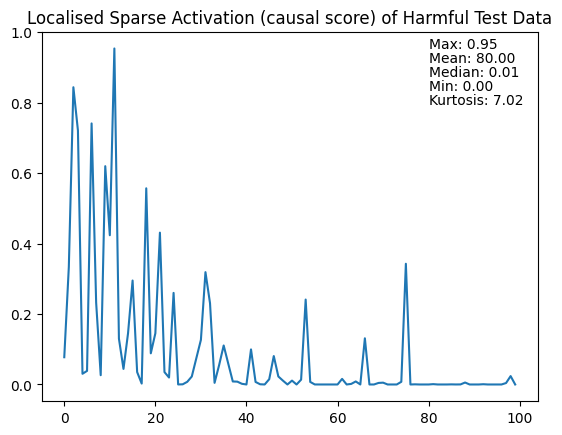

In [189]:
harmful_acts = harmful_acts_test[:, :, top_100_causal]

plt.title('Localised Sparse Activation (causal score) of Harmful Test Data')
harmful_data = harmful_acts[:, -1, :].mean(0)
stats = {
        "max": harmful_data.max(),
        "mean": harmful_data.mean(),
        "median": harmful_data.median(),
        "min": harmful_data.min(), 
        "kurtosis": kurtosis(harmful_data)
    }
# Annotate statistics
plt.text(80, stats['max'] , f"Max: {stats['max']:.2f}", fontsize=10, ha='left')
plt.text(80, stats['max'] - 0.04, f"Mean: {80:.2f}", fontsize=10, ha='left')
plt.text(80, stats['max'] - 0.08, f"Median: {stats['median']:.2f}", fontsize=10, ha='left')
plt.text(80, stats['max'] - 0.12, f"Min: {stats['min']:.2f}", fontsize=10, ha='left')
plt.text(80, stats['max'] - 0.16, f"Kurtosis: {stats['kurtosis']:.2f}", fontsize=10, ha='left')

plt.plot(harmful_acts[:, -1, :].mean(0).detach().numpy())

### by corr / weights: train, test, test_perturbed

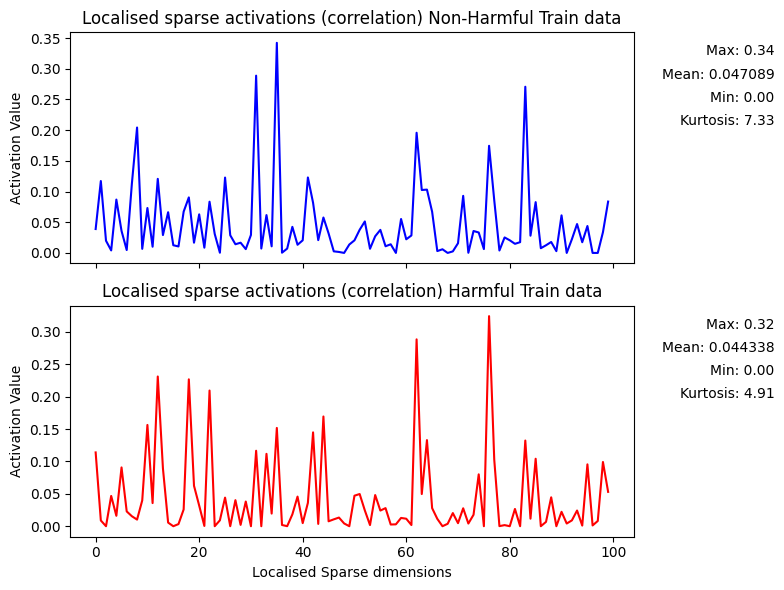

In [175]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import kurtosis

harmful_acts = harmful_sparse_acts_train[:, :, top_100_corr]
nonharmful_acts = nonharmful_sparse_acts_train[:, :, top_100_corr]

harmful_data = harmful_acts[:, -1, :].mean(0)
nonharmful_data = nonharmful_acts[:, -1, :].mean(0)

harmful_stats = {
    "max": harmful_data.max(),
    "mean": harmful_data.mean(),
    "min": harmful_data.min(), 
    "kurtosis": kurtosis(harmful_data)
}
nonharmful_stats = {
    "max": nonharmful_data.max(),
    "mean": nonharmful_data.mean(),
    "min": nonharmful_data.min(), 
    "kurtosis": kurtosis(nonharmful_data)
}

# Create two subplots stacked vertically
fig, axes = plt.subplots(2, 1, figsize=(8, 6), sharex=True)

# Plot non-harmful data
axes[0].plot(nonharmful_data, label="Non-harmful data", color='blue')
axes[0].set_title("Localised sparse activations (correlation) Non-Harmful Train data")
# axes[0].legend()
axes[0].set_ylabel("Activation Value")

# Annotate statistics
axes[0].text(1.25, 0.9, f"Max: {nonharmful_stats['max']:.2f}", transform=axes[0].transAxes, fontsize=10, ha='right')
axes[0].text(1.25, 0.8, f"Mean: {nonharmful_stats['mean']:.6f}", transform=axes[0].transAxes, fontsize=10, ha='right')
axes[0].text(1.25, 0.7, f"Min: {nonharmful_stats['min']:.2f}", transform=axes[0].transAxes, fontsize=10, ha='right')
axes[0].text(1.25, 0.6, f"Kurtosis: {nonharmful_stats['kurtosis']:.2f}", transform=axes[0].transAxes, fontsize=10, ha='right')

# Plot harmful data
axes[1].plot(harmful_data, label="Harmful data", color='red')
axes[1].set_title("Localised sparse activations (correlation) Harmful Train data")

axes[1].set_xlabel("Localised Sparse dimensions")
axes[1].set_ylabel("Activation Value")
# Annotate statistics
axes[1].text(1.25, 0.9, f"Max: {harmful_stats['max']:.2f}", transform=axes[1].transAxes, fontsize=10, ha='right')
axes[1].text(1.25, 0.8, f"Mean: {harmful_stats['mean']:.6f}", transform=axes[1].transAxes, fontsize=10, ha='right')
axes[1].text(1.25, 0.7, f"Min: {harmful_stats['min']:.2f}", transform=axes[1].transAxes, fontsize=10, ha='right')
axes[1].text(1.25, 0.6, f"Kurtosis: {harmful_stats['kurtosis']:.2f}", transform=axes[1].transAxes, fontsize=10, ha='right')


# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


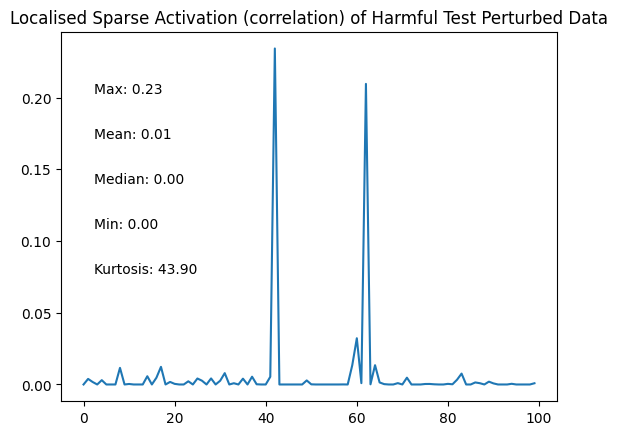

In [ ]:
harmful_acts = harmful_acts_test_perturbed[:, :, top_100_corr]

plt.title('Localised Sparse Activation (correlation) of Harmful Test Perturbed Data')
harmful_data = harmful_acts[:, -1, :].mean(0)
stats = {
        "max": harmful_data.max(),
        "mean": harmful_data.mean(),
        "median": harmful_data.median(),
        "min": harmful_data.min(), 
        "kurtosis": kurtosis(harmful_data)
    }
# Annotate statistics
plt.text(stats['max'] + 2, stats['max'] - harmful_data.std(), f"Max: {stats['max']:.2f}", fontsize=10, ha='left')
plt.text(stats['max'] + 2, stats['max'] - harmful_data.std()*2, f"Mean: {stats['mean']:.2f}", fontsize=10, ha='left')
plt.text(stats['max'] + 2, stats['max'] - harmful_data.std()*3, f"Median: {stats['median']:.2f}", fontsize=10, ha='left')
plt.text(stats['max'] + 2, stats['max'] - harmful_data.std()*4, f"Min: {stats['min']:.2f}", fontsize=10, ha='left')
plt.text(stats['max'] + 2, stats['max'] - harmful_data.std()*5, f"Kurtosis: {stats['kurtosis']:.2f}", fontsize=10, ha='left')

plt.plot(harmful_acts[:, -1, :].mean(0).detach().numpy())


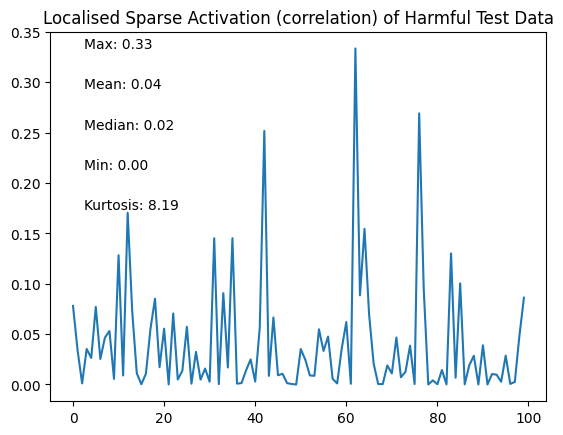

In [180]:
harmful_acts = harmful_acts_test[:, :, top_100_corr]

plt.title('Localised Sparse Activation (correlation) of Harmful Test Data')
harmful_data = harmful_acts[:, -1, :].mean(0)
stats = {
        "max": harmful_data.max(),
        "mean": harmful_data.mean(),
        "median": harmful_data.median(),
        "min": harmful_data.min(), 
        "kurtosis": kurtosis(harmful_data)
    }
# Annotate statistics
plt.text(stats['max'] + 2, stats['max'] , f"Max: {stats['max']:.2f}", fontsize=10, ha='left')
plt.text(stats['max'] + 2, stats['max'] - 0.04, f"Mean: {stats['mean']:.2f}", fontsize=10, ha='left')
plt.text(stats['max'] + 2, stats['max'] - 0.08, f"Median: {stats['median']:.2f}", fontsize=10, ha='left')
plt.text(stats['max'] + 2, stats['max'] - 0.12, f"Min: {stats['min']:.2f}", fontsize=10, ha='left')
plt.text(stats['max'] + 2, stats['max'] - 0.16, f"Kurtosis: {stats['kurtosis']:.2f}", fontsize=10, ha='left')

plt.plot(harmful_acts[:, -1, :].mean(0).detach().numpy())

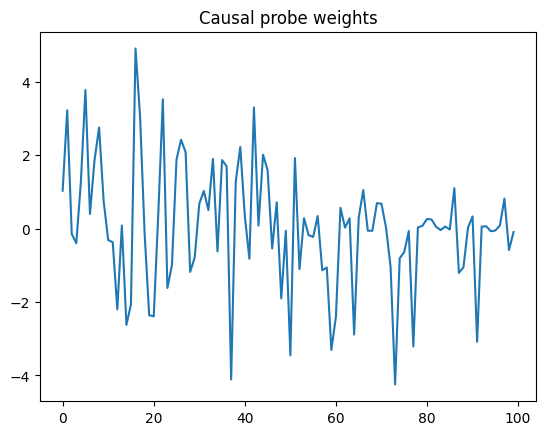

In [156]:
plt.title("Causal probe weights")
plt.plot(causal_local_probe.net.weight[0].detach().numpy())

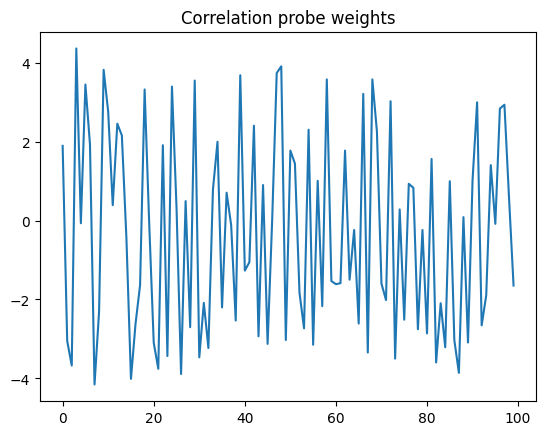

In [155]:
plt.title("Correlation probe weights")
plt.plot(corr_probe.net.weight[0].detach().numpy())